# Attribute Genration

In [195]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from datetime import datetime
import numpy as np
from datetime import datetime
import seaborn as sns

In [186]:
def distance_between(lat1, lon1, lat2, lon2):
    """
    Haversine disance between two coordinates
    """
    R = 6371e3; #meters
    φ1 = np.deg2rad(lat1)
    φ2 = np.deg2rad(lat2)
    Δφ = np.deg2rad(lat2-lat1)
    Δλ = np.deg2rad(lon2-lon1)

    a = np.sin(Δφ/2)*np.sin(Δφ/2) + np.cos(φ1)*np.cos(φ2)*np.sin(Δλ/2)*np.sin(Δλ/2)
    c = 2*np.arctan2(np.sqrt(a), np.sqrt(1-a))

    d = R * c
    return d

def plot_line(line):
    plt.figure(figsize=(10,5))
    plt.title('Line {0}'.format(line.line.iloc[0]))
    plt.plot(line.longitude, line.latitude,'-o')
    plt.show()

def plot_ids_line(line):
    line_ids = line.id.unique()
    plt.figure(figsize=(10,5))
    plt.title(line.line.iloc[0])
    different_ids = len(line_ids)
    colors = pl.cm.jet(np.linspace(0,1,different_ids))
    for size, id_ in enumerate(line_ids):
        l = line[line.id == id_]
        plt.plot(l.longitude, l.latitude, '-o', color=colors[size],markersize=(different_ids-size)*3)
    plt.show()
    
def plot_line_speed(line, show_speeds=True):
    plt.figure(figsize=(17,6))
    plt.title('line: '+str(line.line.iloc[0])+' id: '+str(line.id.iloc[0]))
    max_speed = 100
    min_speed = 0
    speeds = max_speed - min_speed 
    colors = pl.cm.jet(np.linspace(0, 1, speeds + 1))
    sps = []
    for step in line.itertuples():
        plt.plot(step.longitude, step.latitude, '-o', color=colors[int(step.speed)],markersize=step.speed)
        sps.append(str(int(ms_to_kh(step.speed)))+' k/h')
    if show_speeds:
        plt.legend(sps)
    plt.show()
    
def ms_to_kh(ms):
    return (ms*18)/5

In [145]:
data = pd.read_csv('../data/bus_data_stage_1.csv')
data = data.drop(['Unnamed: 0'], axis=1)
data.head()

,id,line,longitude,latitude,timestamp
0,76,217,-56.222400,-34.855885,2018-10-02 14:38:53
1,984,540,-56.201860,-34.909360,2018-10-02 14:39:08
2,288,7898,-56.175415,-34.901110,2018-10-02 14:39:08
3,1111,254,-56.136640,-34.872833,2018-10-02 14:39:08
4,22,540,-56.135277,-34.845554,2018-10-02 14:39:08


In [7]:
unique_lines = data.line.unique()

In [46]:
lines = pd.DataFrame()
for line in unique_lines:
    some_line  = data[data.line == line]
    unique_ids = some_line.id.unique() 
    for bus_id in unique_ids:
        line_by_id = some_line[some_line.id == bus_id]
        data_holder = pd.DataFrame(line_by_id)
        data_holder['next_longitude'] = line_by_id.longitude.shift(-1)
        data_holder['next_latitude']  = line_by_id.latitude.shift(-1)
        data_holder['next_timestamp'] = line_by_id.timestamp.shift(-1)
        data_holder['distance'] = np.zeros(len(data_holder))
        data_holder['distance'] = data_holder.apply(lambda x: distance_between(data_holder.latitude,
                                                                               data_holder.longitude,
                                                                               data_holder.next_latitude,
                                                                               data_holder.next_longitude))
        data_holder.drop(data_holder.index[-1], inplace=True)
        lines = lines.append(data_holder, ignore_index=True)

In [53]:
print('Missing Lines: '+str(len(lines.id.unique()) - len(data.id.unique())))

Missing Lines: -3


Podemos ver que tenemos 3 lineas faltantes en el archivo resultante, vamos a ver cuales son e investigar porque.

In [133]:
np.setdiff1d(data.id.unique(),lines.id.unique())

array([441, 928, 949])

In [123]:
data[data.id == 441]

,id,line,longitude,latitude,timestamp
82,441,372,-56.021667,-34.869667,2018-10-02 14:39:08


In [131]:
data[data.id == 928]

,id,line,longitude,latitude,timestamp
1468,928,372,-56.047527,-34.88614,2018-10-02 14:41:38


In [132]:
data[data.id == 949]

,id,line,longitude,latitude,timestamp
152,949,501,-56.135223,-34.806,2018-10-02 14:39:08


Podemos ver que las lineas faltantes no estan en el dataset resutante porque constan de un solo dato. Podemos considerarlas como outliers e ignorarlas.

In [139]:
line_times  = []
line_speeds = []

for row in lines.itertuples():
    start_time = datetime.strptime(row.timestamp,'%Y-%m-%d %H:%M:%S')
    end_time   = datetime.strptime(row.next_timestamp,'%Y-%m-%d %H:%M:%S')
    time = end_time - start_time
    speed = row.distance/time.total_seconds()
    line_times.append(time)
    line_speeds.append(speed)

lines['time']  = np.zeros(len(lines))
lines['time']  = line_times
lines['speed'] = np.zeros(len(lines))
lines['speed'] = line_speeds
del line_times
del line_speeds

In [140]:
lines.head()

,id,line,longitude,latitude,timestamp,next_longitude,next_latitude,next_timestamp,distance,time,speed
0,76,217,-56.222400,-34.855885,2018-10-02 14:38:53,-56.222717,-34.855766,2018-10-02 14:39:23,31.807877,00:00:30,1.060263
1,76,217,-56.222717,-34.855766,2018-10-02 14:39:23,-56.222733,-34.855780,2018-10-02 14:39:53,2.134200,00:00:30,0.071140
2,76,217,-56.222733,-34.855780,2018-10-02 14:39:53,-56.222916,-34.855682,2018-10-02 14:40:08,19.939152,00:00:15,1.329277
3,76,217,-56.222916,-34.855682,2018-10-02 14:40:08,-56.222866,-34.855682,2018-10-02 14:40:23,4.562295,00:00:15,0.304153
4,76,217,-56.222866,-34.855682,2018-10-02 14:40:23,-56.222850,-34.855667,2018-10-02 14:40:38,2.216614,00:00:15,0.147774


Ahora vamos a revisar los datos calculados

In [192]:
lines.speed.describe()

count    96028.000000
mean         4.455507
std          3.623244
min        -11.337526
25%          1.415347
50%          3.783430
75%          6.725155
max         33.804600
Name: speed, dtype: float64

In [194]:
lines.distance.describe()

count    96028.000000
mean       109.918037
std        557.747270
min          0.000000
25%         23.732101
50%         65.265739
75%        115.928844
max      22490.074027
Name: distance, dtype: float64

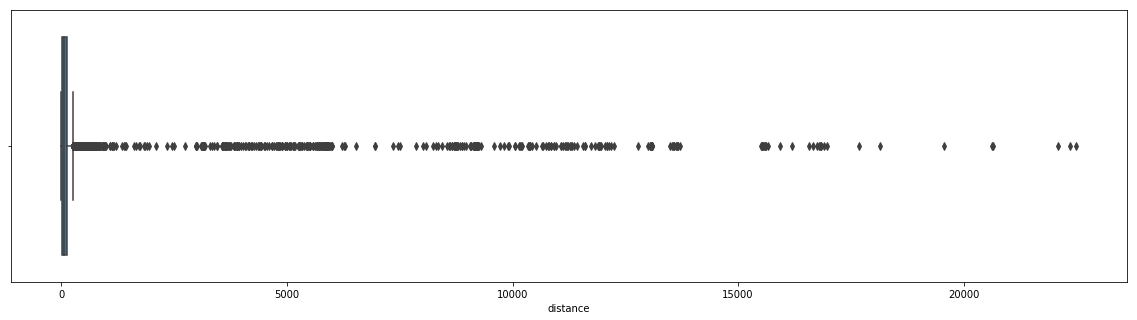

In [218]:
fig, ax = plt.subplots(figsize=(18,5))
ax = sns.boxplot(x=lines.distance)

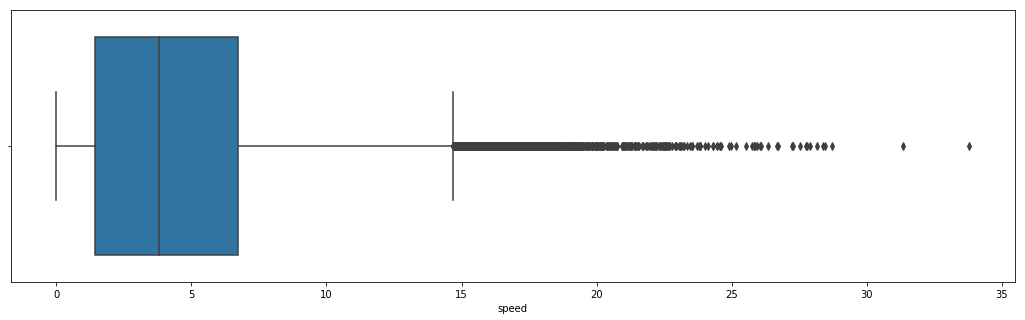

In [219]:
fig, ax = plt.subplots(figsize=(18,5))
ax = sns.boxplot(x=lines.speed)

Podemos ver que tenemos velocidades negativas y que un omnibus se movio 22.5km en un intervalo de tiempo.

In [208]:
negative_speeds = lines.query('speed < 0')
negative_speeds

,id,line,longitude,latitude,timestamp,next_longitude,next_latitude,next_timestamp,distance,time,speed
218,76,217,-56.217384,-34.858532,2018-10-02 17:14:12,-56.217384,-34.858517,2018-10-02 17:13:57,1.667924,-1 days +23:59:45,-0.111195
282,68,217,-56.189632,-34.872250,2018-10-02 14:50:38,-56.189167,-34.873150,2018-10-02 14:50:23,108.694973,-1 days +23:59:45,-7.246332
8311,288,7898,-56.195280,-34.905000,2018-10-02 14:49:38,-56.194637,-34.905000,2018-10-02 14:49:08,58.635926,-1 days +23:59:30,-1.954531
10079,1111,254,-56.142303,-34.850860,2018-10-02 14:49:08,-56.142750,-34.851334,2018-10-02 14:48:53,66.646249,-1 days +23:59:45,-4.443083
11549,26,254,-56.148193,-34.879470,2018-10-02 14:49:38,-56.148804,-34.879917,2018-10-02 14:48:53,74.678565,-1 days +23:59:15,-1.659524
16054,9,2391,-56.170444,-34.899776,2018-10-02 14:50:53,-56.169277,-34.899360,2018-10-02 14:50:38,116.045054,-1 days +23:59:45,-7.736337
16333,94,2391,-56.196835,-34.906140,2018-10-02 14:49:08,-56.195500,-34.906082,2018-10-02 14:48:53,121.909284,-1 days +23:59:45,-8.127286
17648,86,400,-56.167442,-34.898920,2018-10-02 14:49:08,-56.166805,-34.898083,2018-10-02 14:48:38,109.712778,-1 days +23:59:30,-3.657093
17655,86,400,-56.172554,-34.900723,2018-10-02 14:50:53,-56.171030,-34.900223,2018-10-02 14:50:08,149.690867,-1 days +23:59:15,-3.326464
17742,13,2390,-56.194942,-34.905945,2018-10-02 14:49:08,-56.196000,-34.906055,2018-10-02 14:48:53,97.251338,-1 days +23:59:45,-6.483423


Las distancias negativas parecen venir de problemas en los tiempos. Tiempos que parecen estar al revez, primero pasa por el destino y luego por el origen. Como son pocos datos vamos a descartarlos.

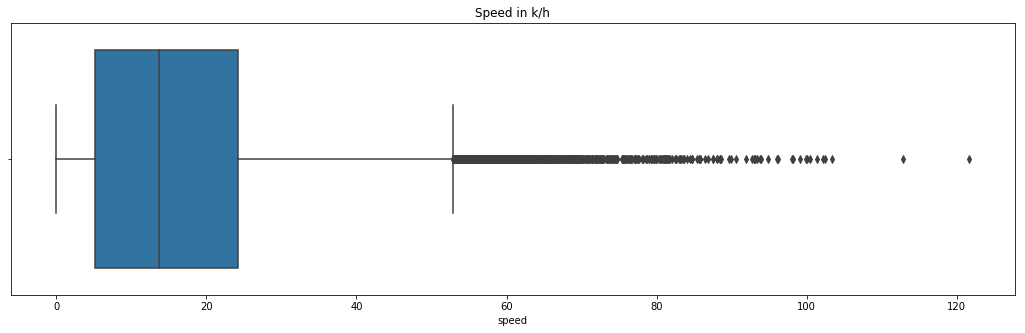

In [230]:
lines = lines.query('speed >= 0')
fig, ax = plt.subplots(figsize=(18,5))
ax.set(title='Speed in k/h')
ax = sns.boxplot(x=lines.speed.apply(lambda x: ms_to_kh(x)))

Ahora tenemos velocidades coherentes y no tenemos outliers que afecten nuestro modelo. Vamos a dejar las velocidades superiores a 15 m/s

In [234]:
large_distances = lines.query('distance > 300')
large_distances

,id,line,longitude,latitude,timestamp,next_longitude,next_latitude,next_timestamp,distance,time,speed
11,76,217,-56.222965,-34.855816,2018-10-02 14:42:38,-56.083332,-34.882233,2018-10-02 16:01:10,13073.155501,01:18:32,2.774439
48,76,217,-56.098970,-34.872250,2018-10-02 16:17:41,-56.106632,-34.870285,2018-10-02 16:19:56,732.347979,00:02:15,5.424800
77,76,217,-56.129200,-34.873450,2018-10-02 16:28:56,-56.133034,-34.871967,2018-10-02 16:29:41,386.688285,00:00:45,8.593073
156,76,217,-56.174600,-34.885185,2018-10-02 16:52:26,-56.178566,-34.887165,2018-10-02 16:53:11,423.478461,00:00:45,9.410632
168,76,217,-56.180183,-34.883415,2018-10-02 16:56:56,-56.187466,-34.880634,2018-10-02 16:59:42,732.776170,00:02:46,4.414314
281,68,217,-56.188300,-34.874718,2018-10-02 14:49:53,-56.189632,-34.872250,2018-10-02 14:50:38,300.127953,00:00:45,6.669510
314,68,217,-56.211967,-34.862183,2018-10-02 14:59:54,-56.214985,-34.860283,2018-10-02 15:00:09,347.072271,00:00:15,23.138151
342,68,217,-56.222830,-34.855732,2018-10-02 15:07:24,-56.083282,-34.882317,2018-10-02 16:25:41,13069.811782,01:18:17,2.782587
363,68,217,-56.088030,-34.877632,2018-10-02 16:38:26,-56.090984,-34.875767,2018-10-02 16:38:41,340.030540,00:00:15,22.668703
510,68,217,-56.181750,-34.882800,2018-10-02 17:23:42,-56.186150,-34.881134,2018-10-02 17:25:27,442.043685,00:01:45,4.209940


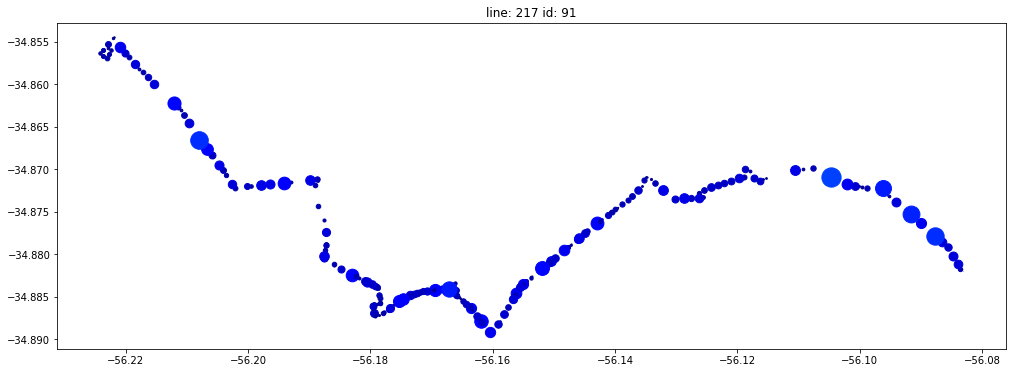

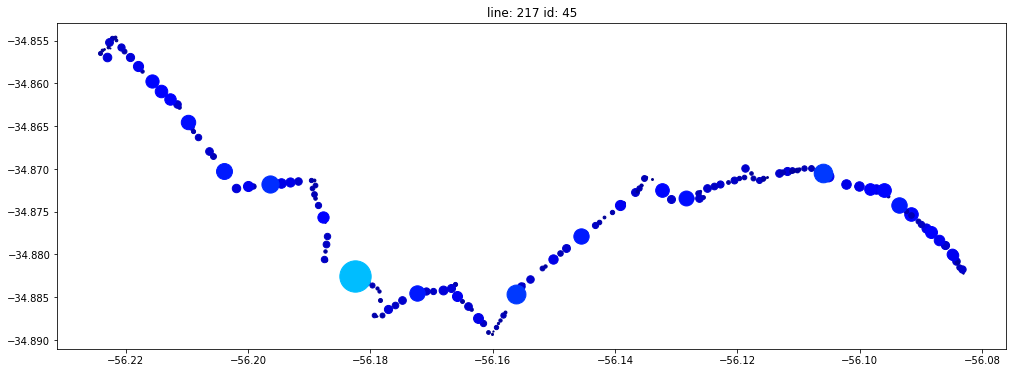

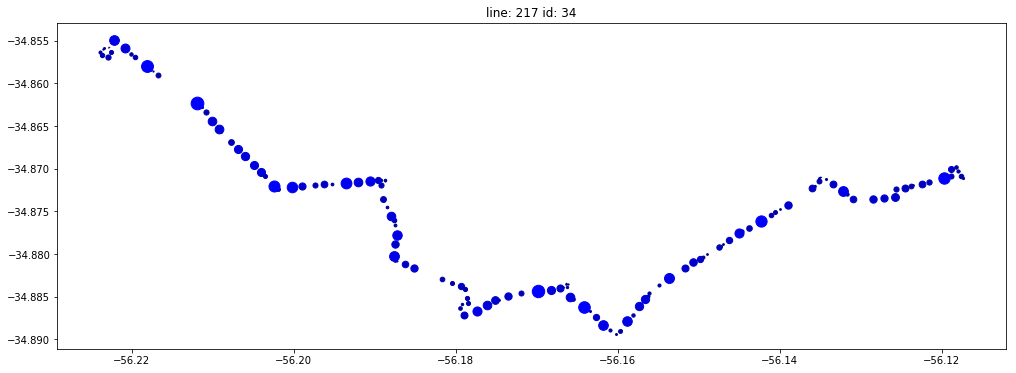

In [187]:
unique_ids = lines.id.unique()
for _id in unique_ids[5:8]:
    line = lines.query('id == {0} & line == 217'.format(_id))
    plot_line_speed(line, False)

In [235]:
import shapefile

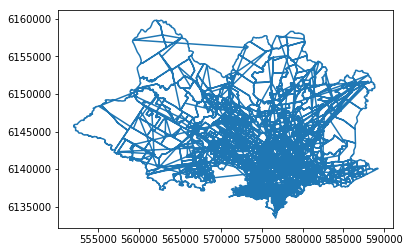

In [240]:
shpFilePath = "../../../Downloads/Shapex/sectoresFix.shp"
listx=[]
listy=[]
test = shapefile.Reader(shpFilePath)
for sr in test.shapeRecords():
    for xNew,yNew in sr.shape.points:
        listx.append(xNew)
        listy.append(yNew)
plt.plot(listx,listy)